<a href="https://colab.research.google.com/github/masalha-alaa/sign-language-digits-keras/blob/master/sign_language_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sign Language Digits Classification

## Imports

In [1]:
import os
from datetime import datetime
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import callbacks, layers
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
from pathlib import Path
import zipfile
import re

SEED = 42
BATCH_SIZE = 32
EPOCHS = 32

## Mount drive

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## GPU

In [3]:
# Use GPU if available

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Running on GPU')
else:
    print('Running on CPU')

Running on GPU


## Extract data

In [4]:
# Extract data from zip file

DATA_DIR = Path("/content/gdrive/MyDrive/sign-language-digits-project/")
DATASET_ZIP = 'Sign-Language-Digits-Dataset-master.zip'
DATASET_EXTRACT = Path('TEMP')

if not os.path.exists(DATASET_EXTRACT):
    ts = datetime.now()
    print('Extracting data...')
    with zipfile.ZipFile(DATA_DIR / DATASET_ZIP, 'r') as z:
        for filename in z.namelist():
            if filename.startswith('Sign-Language-Digits-Dataset-master/Dataset/'):
                z.extract(filename, DATASET_EXTRACT)
    print('Done')
    print(datetime.now() - ts)

# create absolute paths (will load images later)
dataset_raw = [Path(root) / filename for root,_,filenames in os.walk(DATASET_EXTRACT) for filename in filenames if filename.endswith('.JPG')]
NUM_CLASSES = len(np.unique(dataset_raw))

# shuffle dataset
np.random.seed(SEED)
np.random.shuffle(dataset_raw)

print(f"{len(dataset_raw)} files")

2062 files


## Peek at the data

In [5]:
def lbl_from_path(path):
    return int(re.search('\/(\d)\/', str(path)).groups(1)[0])

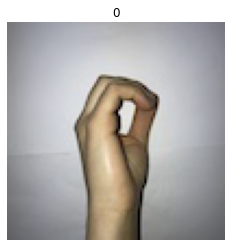

In [6]:
# Show random image

np.random.seed(SEED)
SAMPLE_IMG_ID = np.random.choice(len(dataset_raw))

sample_img, sample_img_label = Image.open(dataset_raw[SAMPLE_IMG_ID]), lbl_from_path(dataset_raw[SAMPLE_IMG_ID])
IMAGE_SHAPE = np.array(sample_img).shape
plt.axis(False)
junk = plt.imshow(sample_img)
junk = plt.title(sample_img_label)

## Load images and split dataset

In [7]:
# read images from paths and split to train / test

TRAIN_FRAC = 0.80

x_train, y_train = [], []
x_test, y_test = [], []

def valid_image(img_):
    # turns out there are invalid images in the dataset
    return img_.shape == IMAGE_SHAPE

def read_imgs(from_, to_, dataset):
    x, y = [], []
    for i in range(from_, to_):
        path = dataset[i]
        img = np.array(Image.open(path))
        if valid_image(img):
            x.append(img)
            y.append(lbl_from_path(path))
    return x, y

# split to train / test
x_train, y_train = read_imgs(0, int(TRAIN_FRAC * len(dataset_raw)), dataset_raw)
x_test, y_test = read_imgs(int(TRAIN_FRAC * len(dataset_raw)), len(dataset_raw), dataset_raw)

# convert to numpy array to work with Keras
x_train, x_test = np.array(x_train), np.array(x_test)

print(f'Training set: {len(x_train)}, Labels: {np.unique(y_train)}')
print(f'Test set: {len(x_test)}, Labels: {np.unique(y_test)}')

Training set: 1646, Labels: [0 1 2 3 4 5 6 7 8 9]
Test set: 413, Labels: [0 1 2 3 4 5 6 7 8 9]


## Model

In [8]:
# Label one hot encoding
y_train, y_test = to_categorical(y_train, NUM_CLASSES), to_categorical(y_test, NUM_CLASSES)
print(f'Output examples:\n{y_train[:5]}\n')

# Define callbacks
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.01,
    restore_best_weights=True,
    verbose=1
)
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

# Build model
model = keras.Sequential([
    layers.InputLayer(IMAGE_SHAPE),
    tf.keras.layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),

    # Data Augmentation (runs only in training) [START]
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='nearest'),
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.1, fill_mode='nearest'),
    # Data Augmentation [END]

    tf.keras.layers.BatchNormalization(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(2),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(2),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPool2D(2),

    layers.Flatten(),

    layers.Dense(1024, activation='relu'),

    layers.Dense(1024, activation='relu'),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

loss = keras.losses.CategoricalCrossentropy()
optim = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

Output examples:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 100, 100, 1)       0         
_________________________________________________________________
random_translation (RandomTr (None, 100, 100, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 100, 100, 1)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 100, 100, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100

## Fit Model

In [9]:
# Fit and save history for plotting
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_callback, reduce_lr_callback], validation_data=(x_test, y_test), verbose=2)

Epoch 1/32
52/52 - 34s - loss: 2.6999 - accuracy: 0.1883 - val_loss: 2.0168 - val_accuracy: 0.2518
Epoch 2/32
52/52 - 1s - loss: 1.5088 - accuracy: 0.4721 - val_loss: 1.1645 - val_accuracy: 0.5835
Epoch 3/32
52/52 - 1s - loss: 1.0587 - accuracy: 0.6221 - val_loss: 0.6877 - val_accuracy: 0.7530
Epoch 4/32
52/52 - 1s - loss: 0.7666 - accuracy: 0.7345 - val_loss: 0.2778 - val_accuracy: 0.9080
Epoch 5/32
52/52 - 1s - loss: 0.5405 - accuracy: 0.8135 - val_loss: 0.2657 - val_accuracy: 0.9056
Epoch 6/32
52/52 - 1s - loss: 0.4115 - accuracy: 0.8682 - val_loss: 0.2320 - val_accuracy: 0.9346
Epoch 7/32
52/52 - 1s - loss: 0.3167 - accuracy: 0.8943 - val_loss: 0.1752 - val_accuracy: 0.9419
Epoch 8/32
52/52 - 1s - loss: 0.3277 - accuracy: 0.8906 - val_loss: 0.2034 - val_accuracy: 0.9298
Epoch 9/32
52/52 - 1s - loss: 0.2593 - accuracy: 0.9143 - val_loss: 0.1913 - val_accuracy: 0.9467
Epoch 10/32
52/52 - 1s - loss: 0.2271 - accuracy: 0.9247 - val_loss: 0.1500 - val_accuracy: 0.9613
Epoch 11/32
52/52 

## Plot Progression

(0.0, 1.0)

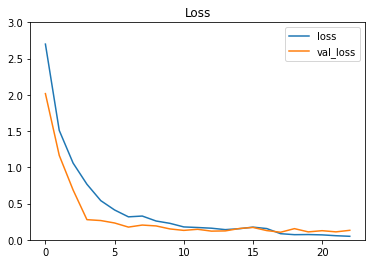

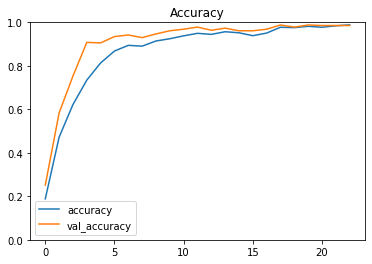

In [10]:
# Plot history
history_df = pd.DataFrame(history.history)
loss_ax = history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
acc_ax = history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Accuracy')
loss_ax.set_ylim(0, 3)
acc_ax.set_ylim(0, 1)

## Evaluate

In [11]:
# Evaluate on test set
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)

13/13 [==============================] - 0s 9ms/step - loss: 0.1043 - accuracy: 0.9879


[0.10434318333864212, 0.9878934621810913]

## Prediction Example

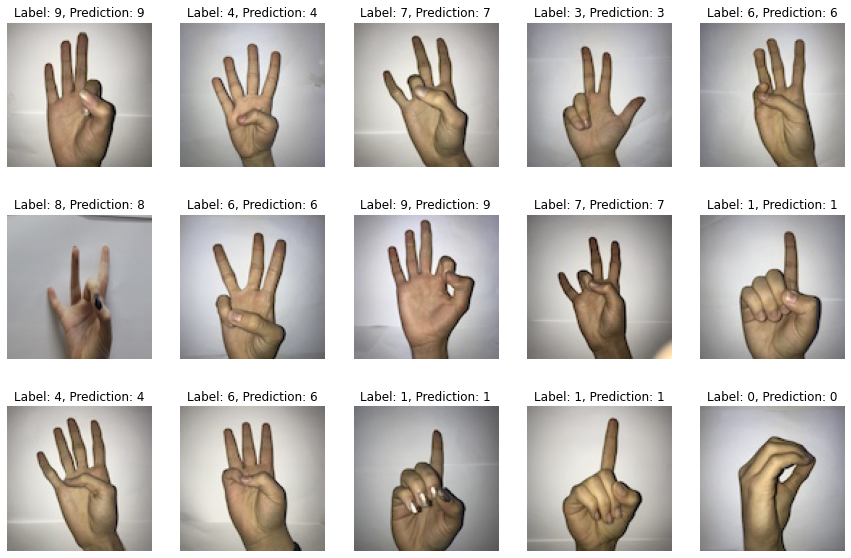

In [12]:
# Run model on some test examples and show results

fig = plt.figure(figsize=(15, 10))
fig.tight_layout(pad=1.0)

indices = np.random.choice(len(x_test), size=15, replace=False)
cols = 5
for i,idx in enumerate(indices):
    plt.subplot(len(indices) // cols, cols, i+1)
    img = x_test[idx]
    plt.imshow(img)
    pred = np.argmax(model(np.expand_dims(img, 0), training=False))
    lbl = np.argmax(y_test[idx])
    plt.title(f'Label: {lbl}, Prediction: {pred}')
    plt.axis('off')

plt.show()